In [1]:
!pip install -U xformers --index-url https://download.pytorch.org/whl/cu124

Looking in indexes: https://download.pytorch.org/whl/cu124
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 55.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 62.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 119.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 867.6 kB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 11.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 72.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.4/43.4 MB 15.1 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Fo

In [2]:
!pip install -q transformers diffusers accelerate ftfy triton pytorch-lightning einops
!pip install -q pytesseract opencv-python pillow

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.8/44.8 kB 2.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 823.1/823.1 kB 43.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 961.5/961.5 kB 51.4 MB/s eta 0:00:00


In [ ]:
"SG161222/Realistic_Vision_V6.0"
"SG161222/RealVisXL_V3.0"
"stablediffusionapi/juggernaut-xl-v8"
"Alias/Architectural-Diffusion-XL"

🏠 Pakistani House Front View Generator 🏠
📊 Please upload your floor plan image...


Saving testing_1Floor_only.jpg to testing_1Floor_only (2).jpg
🔍 Extracted text from floor plan:

🏠 House Analysis:
  - Bedrooms detected: 1
  - Stairs mentioned: False
  - Second floor mentioned: False
  - Balcony detected: False
  - Terrace detected: False
  - Porch/Veranda detected: False
  - Number of floors: 1
🧠 Loading SDXL RealVisXL V3.0 model...


Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

🔍 Prompt POSITIVE:
 Ultra-realistic front view of a strictly single-story modern 5 or 10 marla ho
🔍 Prompt NEGATIVE:
 second floor, second level, two-story, double story, upper floor, 2nd floor, 


  0%|          | 0/45 [00:00<?, ?it/s]

  0%|          | 0/45 [00:00<?, ?it/s]

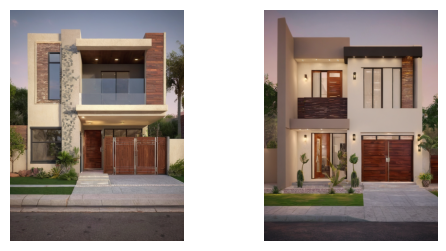

✅ Generated 2 variations in output/OneFloor_4156688483


In [9]:
import os
import torch
import pytesseract
import cv2
from PIL import Image, ImageDraw, ImageFont
import re
import numpy as np
from diffusers import StableDiffusionPipeline, StableDiffusionXLPipeline, UniPCMultistepScheduler
from transformers import CLIPTokenizer
from google.colab import files
import time
import matplotlib.pyplot as plt

def clamp_prompt(prompt, max_length=77):
    return prompt[:max_length]

# STEP 1: Upload and Process Floor Plan
def analyze_floor_plan():
    print("📊 Please upload your floor plan image...")
    uploaded = files.upload()
    img_path = next(iter(uploaded))
    img = cv2.imread(img_path)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    gray = cv2.GaussianBlur(gray, (5, 5), 0)
    _, thresh = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    text = pytesseract.image_to_string(thresh)
    text_clean = re.sub(r"[^a-zA-Z0-9\s]", " ", text.lower())
    text_clean = re.sub(r"\s+", " ", text_clean).strip()
    print(f"🔍 Extracted text from floor plan:\n{text_clean}")
    return text_clean, img_path

# STEP 2: Analyze House Characteristics
def analyze_house_characteristics(text_clean):
    bed_keywords = [
        r"\b(\d+)\s*(bed|bedroom|br|bd|b/r)s?\b",
        r"\b(one|two|three|four|five|six|seven|eight|nine|ten|1|2|3|4|5|6|7|8)\s*(bed|bedroom|br|bd|b/r)s?\b",
        r"\bmaster\s*(bed|bedroom|br|bd|b/r)s?\b",
        r"\bguest\s*(bed|bedroom|br|bd|b/r)s?\b"
    ]
    bedroom_count = 0
    for pattern in bed_keywords:
        for match in re.findall(pattern, text_clean):
            num = match[0]
            if num.isdigit(): bedroom_count += int(num)
            else:
                word_to_num = {**{str(i):i for i in range(1,11)},
                               'one':1,'two':2,'three':3,'four':4,'five':5,'six':6,
                               'seven':7,'eight':8,'nine':9,'ten':10,'master':1,'guest':1}
                bedroom_count += word_to_num.get(num, 1)
    bedroom_count = max(bedroom_count, 1)

    has_stairs = bool(re.search(r"\b(stair|stairs|staircase|stairway)\b", text_clean))
    has_second = bool(re.search(r"\b(second|2nd|upper|top)\s*(floor|story|level)\b", text_clean))
    has_ground = bool(re.search(r"\b(ground|first|1st)\s*(floor|story|level)\b", text_clean))

    if has_second or (bedroom_count >=3 and has_stairs): num_floors = 2
    elif bedroom_count >=4: num_floors = 2
    else: num_floors = 1

    has_balcony = bool(re.search(r"\b(balcony|balconies)\b", text_clean))
    has_terrace = bool(re.search(r"\b(terrace|terrace garden)\b", text_clean))
    has_porch = bool(re.search(r"\b(porch|veranda|verandah)\b", text_clean))
    if (has_balcony or has_terrace) and num_floors==1: num_floors=2

    print("🏠 House Analysis:")
    print(f"  - Bedrooms detected: {bedroom_count}")
    print(f"  - Stairs mentioned: {has_stairs}")
    print(f"  - Second floor mentioned: {has_second}")
    print(f"  - Balcony detected: {has_balcony}")
    print(f"  - Terrace detected: {has_terrace}")
    print(f"  - Porch/Veranda detected: {has_porch}")
    print(f"  - Number of floors: {num_floors}")

    return {'bedroom_count':bedroom_count,'num_floors':num_floors,
            'has_balcony':has_balcony,'has_porch':has_porch} #'bedroom_count':bedroom_count,'num_floors':num_floors,
            #'has_balcony':has_balcony,'has_porch':has_porch

# STEP 3: Load Stable Diffusion Model
def load_model():
    print("🧠 Loading SDXL RealVisXL V3.0 model...")
    pipe = StableDiffusionXLPipeline.from_pretrained(
        "SG161222/RealVisXL_V3.0",
        torch_dtype=torch.float16,
        local_files_only=False
        #variant="fp16",
        #use_safetensors=True,
        #safety_checker=None  # Disable safety checker for full control (optional)
    ).to("cuda")

    pipe.enable_xformers_memory_efficient_attention()
    pipe.enable_vae_tiling()  # Optional, helps with large resolutions
    return pipe

# STEP 4: Generate Prompt (with landscape context)
def generate_prompt(hc):
    if hc['num_floors'] == 1:
        pos = (
            "Ultra-realistic front view of a strictly single-story modern 5 or 10 marla house in Pakistan, one floor only,strictly one level, one-level house, absolutely no second floor or mumty, flat roof, boxy compact layout, white and navy-blue color scheme, clean symmetrical design, wide main gate, modern boundary wall, no balcony, minimal landscaping, centered camera, architectural photo, 4K quality, daylight"
            )

        neg = (
            "second floor, second level, two-story, double story, upper floor, 2nd floor, stairs, mumty, roof room, balcony, terrace, terrace room, extra height, sloped roof, slanted roof, third floor, third level, penthouse, top floor, railing, hut, blurry, people, birds"
            )
    else:
        pos = (
           "Ultra-realistic front view of a modern 5 or 10 marla two-story house in Pakistan, clean navy-blue and white facade, rectangular structure, boxy design, wide windows with glass railings, single large main gate, second floor clearly visible but no third floor or mumty, symmetrical layout, soft lighting, concrete driveway, centered camera, daylight, 4K quality, professional architecture photo"
        )
        neg = (
            "third floor, three-story, extra floor, mumty, rooftop structure, roof room, extra height, hut, third level, penthouse, top floor, sloped roof, terrace room, blurry, people, birds, garden"
        )

    return clamp_prompt(pos), clamp_prompt(neg)


# STEP 5: Generate & Save Variations
def generate_and_validate(pipe,prompt,negative,hc,num_var=2):
    seed0=torch.randint(0,2**32,(1,)).item()
    gen0=torch.Generator(device="cuda").manual_seed(seed0)
    imgs=[]
    for i in range(num_var):
        img = pipe(prompt=prompt,
           negative_prompt=negative,
           guidance_scale=6.5,
           num_inference_steps=45,
           generator=gen0,
           height=1024,
           width=768).images[0]
        imgs.append(img)
        tag="OneFloor" if hc['num_floors']==1 else "TwoFloors"
        out_dir=f"output/{tag}_{seed0}"
        os.makedirs(out_dir,exist_ok=True)
        img.save(os.path.join(out_dir,f"{tag}_v{i+1}_clean.png"))
        # annotate
        meta=img.copy().convert("RGBA")
        bg=Image.new("RGBA",meta.size,(0,0,0,0))
        dr=ImageDraw.Draw(bg);dr.rectangle([(10,10),(350,120)],fill=(0,0,0,128))
        ann=Image.alpha_composite(meta,bg).convert("RGB")
        draw=ImageDraw.Draw(ann);fnt=ImageFont.load_default();y=15
        for ln in [f"Floors: {hc['num_floors']}",f"Beds: {hc['bedroom_count']}",f"Balcony: {'Yes' if hc['has_balcony'] else 'No'}",f"Seed: {seed0}"]:
            draw.text((15,y),ln,fill=(255,255,255),font=fnt);y+=20
        ann.save(os.path.join(out_dir,f"{tag}_v{i+1}_ann.png"))
    # display grid
    fig,axes=plt.subplots(1,num_var,figsize=(num_var*3,3))
    for ax,img in zip(axes,imgs): ax.imshow(img);ax.axis('off')
    plt.show()
    print(f"✅ Generated {num_var} variations in output/{tag}_{seed0}")

# STEP 6: Main
def generate_house_front_view():
    print("🏠 Pakistani House Front View Generator 🏠")
    text_clean,_=analyze_floor_plan()
    hc=analyze_house_characteristics(text_clean)
    pipe=load_model()
    pos,neg=generate_prompt(hc)
    print("🔍 Prompt POSITIVE:\n",pos)
    print("🔍 Prompt NEGATIVE:\n",neg)
    generate_and_validate(pipe,pos,neg,hc,num_var=2)

if __name__=="__main__":
    generate_house_front_view()

🏠 Pakistani House Front View Generator 🏠
📊 Please upload your floor plan image...


Saving testing_1Floor_only.jpg to testing_1Floor_only (1).jpg
🔍 Extracted text from floor plan:

🏠 House Analysis:
  - Bedrooms detected: 1
  - Stairs mentioned: False
  - Second floor mentioned: False
  - Balcony detected: False
  - Terrace detected: False
  - Porch/Veranda detected: False
  - Number of floors: 1
🧠 Loading SDXL RealVisXL V3.0 model...


Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

🔍 Prompt POSITIVE:
 Ultra-realistic front view of a strictly single-story modern 5 or 10 marla ho
🔍 Prompt NEGATIVE:
 second floor, second level, two-story, double story, upper floor, 2nd floor, 


  0%|          | 0/45 [00:00<?, ?it/s]

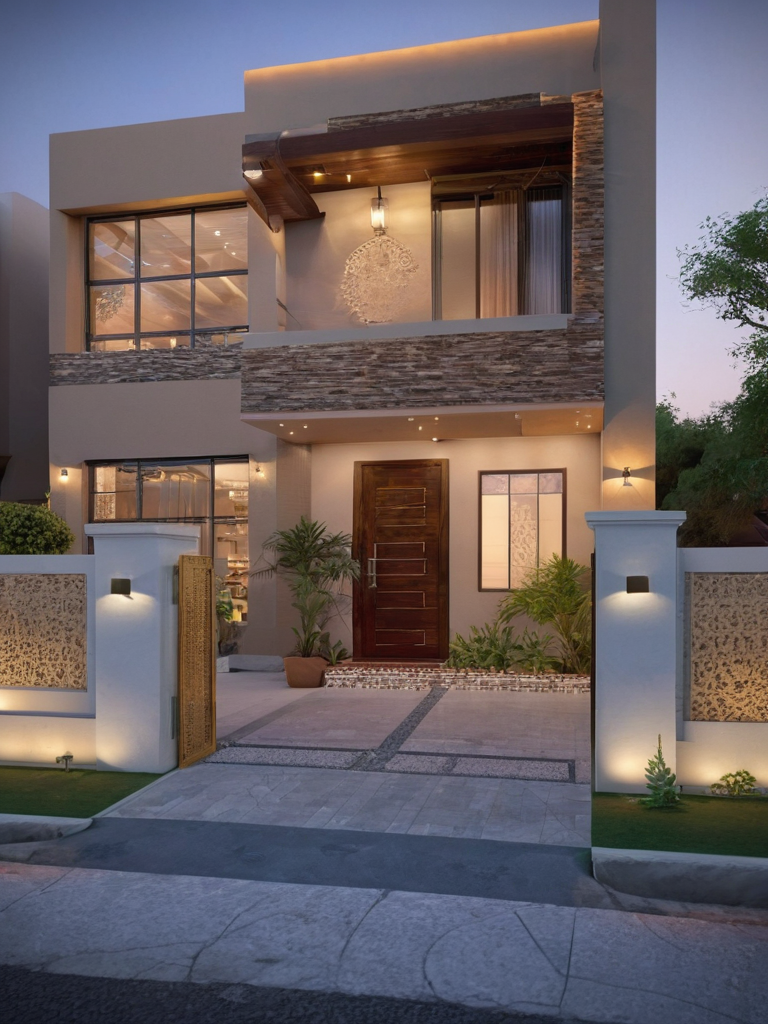

  0%|          | 0/45 [00:00<?, ?it/s]

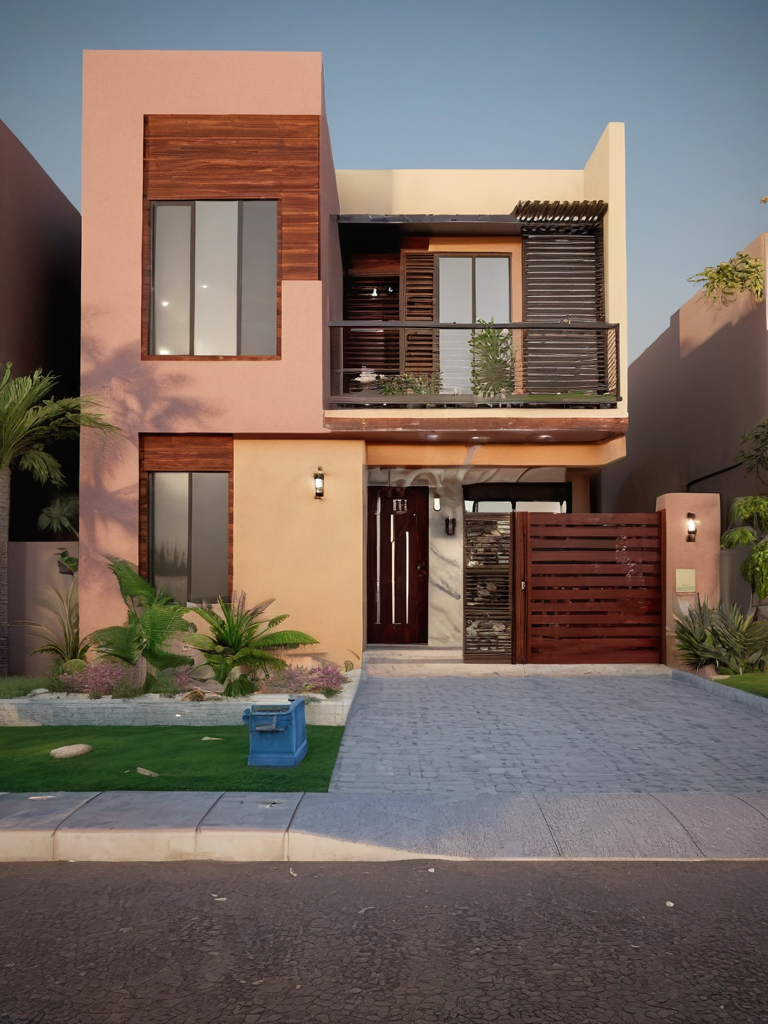

In [8]:
import os
import torch
import pytesseract
import cv2
from PIL import Image
import re
import numpy as np
from diffusers import StableDiffusionXLPipeline
from google.colab import files
from IPython.display import display

def clamp_prompt(prompt, max_length=77):
    return prompt[:max_length]

# STEP 1: Upload and Process Floor Plan
def analyze_floor_plan():
    print("📊 Please upload your floor plan image...")
    uploaded = files.upload()
    img_path = next(iter(uploaded))
    img = cv2.imread(img_path)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    gray = cv2.GaussianBlur(gray, (5, 5), 0)
    _, thresh = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    text = pytesseract.image_to_string(thresh)
    text_clean = re.sub(r"[^a-zA-Z0-9\s]", " ", text.lower())
    text_clean = re.sub(r"\s+", " ", text_clean).strip()
    print(f"🔍 Extracted text from floor plan:\n{text_clean}")
    return text_clean, img_path

# STEP 2: Analyze House Characteristics
def analyze_house_characteristics(text_clean):
    bed_keywords = [
        r"\b(\d+)\s*(bed|bedroom|br|bd|b/r)s?\b",
        r"\b(one|two|three|four|five|six|seven|eight|nine|ten|1|2|3|4|5|6|7|8)\s*(bed|bedroom|br|bd|b/r)s?\b",
        r"\bmaster\s*(bed|bedroom|br|bd|b/r)s?\b",
        r"\bguest\s*(bed|bedroom|br|bd|b/r)s?\b"
    ]
    bedroom_count = 0
    for pattern in bed_keywords:
        for match in re.findall(pattern, text_clean):
            num = match[0]
            if num.isdigit(): bedroom_count += int(num)
            else:
                word_to_num = {
                    **{str(i): i for i in range(1, 11)},
                    'one': 1, 'two': 2, 'three': 3, 'four': 4, 'five': 5,
                    'six': 6, 'seven': 7, 'eight': 8, 'nine': 9, 'ten': 10,
                    'master': 1, 'guest': 1
                }
                bedroom_count += word_to_num.get(num, 1)
    bedroom_count = max(bedroom_count, 1)

    has_stairs = bool(re.search(r"\b(stair|stairs|staircase|stairway)\b", text_clean))
    has_second = bool(re.search(r"\b(second|2nd|upper|top)\s*(floor|story|level)\b", text_clean))
    has_ground = bool(re.search(r"\b(ground|first|1st)\s*(floor|story|level)\b", text_clean))

    if has_second or (bedroom_count >= 3 and has_stairs): num_floors = 2
    elif bedroom_count >= 4: num_floors = 2
    else: num_floors = 1

    has_balcony = bool(re.search(r"\b(balcony|balconies)\b", text_clean))
    has_terrace = bool(re.search(r"\b(terrace|terrace garden)\b", text_clean))
    has_porch = bool(re.search(r"\b(porch|veranda|verandah)\b", text_clean))
    if (has_balcony or has_terrace) and num_floors == 1:
        num_floors = 2

    print("🏠 House Analysis:")
    print(f"  - Bedrooms detected: {bedroom_count}")
    print(f"  - Stairs mentioned: {has_stairs}")
    print(f"  - Second floor mentioned: {has_second}")
    print(f"  - Balcony detected: {has_balcony}")
    print(f"  - Terrace detected: {has_terrace}")
    print(f"  - Porch/Veranda detected: {has_porch}")
    print(f"  - Number of floors: {num_floors}")

    return {
        'bedroom_count': bedroom_count,
        'num_floors': num_floors,
        'has_balcony': has_balcony,
        'has_porch': has_porch
    }

# STEP 3: Load Stable Diffusion Model
def load_model():
    print("🧠 Loading SDXL RealVisXL V3.0 model...")
    pipe = StableDiffusionXLPipeline.from_pretrained(
        "SG161222/RealVisXL_V3.0",
        torch_dtype=torch.float16
    ).to("cuda")
    pipe.enable_xformers_memory_efficient_attention()
    pipe.enable_vae_tiling()
    return pipe

# STEP 4: Generate Prompt
def generate_prompt(hc):
    if hc['num_floors'] == 1:
        pos = (
            "Ultra-realistic front view of a strictly single-story modern 5 or 10 marla house in Pakistan, one floor only, absolutely no second floor or mumty, flat roof, boxy compact layout, white and navy-blue color scheme, clean symmetrical design, wide main gate, modern boundary wall, no balcony, minimal landscaping, centered camera, architectural photo, 4K quality, daylight"
            )

        neg = (
            "second floor, second level, two-story, double story, upper floor, 2nd floor, stairs, mumty, roof room, balcony, terrace, terrace room, extra height, sloped roof, slanted roof, third floor, third level, penthouse, top floor, railing, hut, blurry, people, birds"
            )

    else:
        pos = (
            "Ultra-realistic front view of a modern 5 or 10 marla two-story house in Pakistan, clean navy-blue and white facade, rectangular structure, boxy design, wide windows with glass railings, single large main gate, second floor clearly visible but no third floor or mumty, symmetrical layout, soft lighting, concrete driveway, centered camera, daylight, 4K quality, professional architecture photo"
        )
        neg = (
            "third floor, three-story, extra floor, mumty, rooftop structure, roof room, extra height, hut, third level, penthouse, top floor, sloped roof, terrace room, blurry, people, birds, garden"
        )
    return clamp_prompt(pos), clamp_prompt(neg)

# ✅ Utility to get next available run number
def get_next_run_index(base_dir, tag):
    os.makedirs(base_dir, exist_ok=True)
    existing = [d for d in os.listdir(base_dir) if d.startswith(tag + "_")]
    nums = [int(name.split("_")[-1]) for name in existing if name.split("_")[-1].isdigit()]
    return max(nums + [0]) + 1

# STEP 5: Generate & Save Variations (cleaned + integrated)
def generate_and_validate(pipe, prompt, negative, hc, num_var=2):
    seed0 = torch.randint(0, 2**32, (1,)).item()
    gen0 = torch.Generator(device="cuda").manual_seed(seed0)
    imgs = []

    tag = "OneFloor" if hc['num_floors'] == 1 else "TwoFloor"
    base_dir = "Output_Exterior"
    run_index = get_next_run_index(base_dir, tag)
    out_dir = os.path.join(base_dir, f"{tag}_{run_index}")
    os.makedirs(out_dir, exist_ok=True)

    for i in range(num_var):
        img = pipe(
            prompt=prompt,
            negative_prompt=negative,
            guidance_scale=7.5,
            num_inference_steps=45,
            generator=gen0,
            height=1024,
            width=768
        ).images[0]
        imgs.append(img)
        img_path = os.path.join(out_dir, f"{i+1}_variation.png")
        img.save(img_path)
        display(img)

# STEP 6: Main Pipeline
def generate_house_front_view():
    print("🏠 Pakistani House Front View Generator 🏠")
    text_clean, _ = analyze_floor_plan()
    hc = analyze_house_characteristics(text_clean)
    pipe = load_model()
    pos, neg = generate_prompt(hc)
    print("🔍 Prompt POSITIVE:\n", pos)
    print("🔍 Prompt NEGATIVE:\n", neg)
    generate_and_validate(pipe, pos, neg, hc, num_var=2)

# Run
if __name__ == "__main__":
    generate_house_front_view()